# Deep Homography Estimation
### Esteban Reyes Saldaña
Implementation of [Deep Homography Estimation](https://arxiv.org/pdf/1606.03798.pdf)


june 5, 2023

# DataLoader

In [1]:
import glob
import os
import time
import torch
import torch.nn as nn
from tqdm import tqdm
from torchinfo import summary
import torch.optim as optim
import numpy as np

from torch.utils.data import Dataset, DataLoader

/home/esteban/anaconda3/envs/torchtensor/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class CocoDataset(Dataset) :
    def __init__(self, path) :
        self.files = [os.path.join(path,f) for f in os.listdir(path)]
    def __getitem__(self, index) :
        raw  = np.load(self.files[index], allow_pickle=True)
        x, y = raw
        # change channels to the end
        x = x.transpose(2, 0, 1)
        ## to tensor
        x = torch.from_numpy(x).float()
        y = torch.from_numpy(y).float()
        # range to [-1, 1]
        x = x / 127.5 - 1.
        y = y / 32.
        return x, y
    
    def __len__(self) :
        return len(self.files)

In [3]:
train_folder = r'/home/esteban/Data/COCO/Homography/train/'
val_folder   = r'/home/esteban/Data/COCO/Homography/val/'
batch_size   = 64

In [4]:
len(os.listdir(val_folder))

5000

In [5]:
TrainingData   = CocoDataset(train_folder)
ValidationData = CocoDataset(val_folder)

In [6]:
dataloader_train = DataLoader(TrainingData,   batch_size = batch_size, shuffle=True, num_workers=batch_size)
dataloader_val   = DataLoader(ValidationData, batch_size = batch_size, shuffle=True, num_workers=batch_size)

# Model

In [7]:
def ConvBlock(input_size = 2, out_size = 64, kernel_size = 3, max_polling = False) :
    convblock = []
    convblock.append(nn.Conv2d(input_size, out_size, kernel_size, padding = 1))
    convblock.append(nn.BatchNorm2d(out_size))
    convblock.append(nn.ReLU())
           
    if max_polling :
        convblock.append(nn.MaxPool2d(2))
    
    return nn.Sequential(*convblock)

In [8]:
class Deep_Model(nn.Module) :
    def __init__(self, input_dim) :
        super(Deep_Model, self).__init__()
        
        self.input_dim = input_dim
        self.input_layer = ConvBlock(input_size = 2, out_size = 64)
        self.layer2      = ConvBlock(input_size = 64, out_size = 64, max_polling = True)
        self.layer3      = ConvBlock(input_size = 64, out_size = 64)
        self.layer4      = ConvBlock(input_size = 64, out_size = 64, max_polling = True)
        self.layer5      = ConvBlock(input_size = 64, out_size = 128)
        self.layer6      = ConvBlock(input_size = 128, out_size = 128, max_polling = True)
        self.layer7      = ConvBlock(input_size = 128, out_size = 128)
        self.layer8      = ConvBlock(input_size = 128, out_size = 128)
        
        self.last_conv_dim = 128 * (self.input_dim[1] // 8) * (self.input_dim[2] // 8)
        self.dense1        = nn.Linear(self.last_conv_dim, 1024)

    def forward(self, x) :
        x = self.input_layer(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)
        x = self.layer8(x)
        # flat input
        x = x.view(-1, self.last_conv_dim)
        x = self.dense1(x)

        return x

In [9]:
class Deep_Homography(nn.Module) :
    def __init__(self, input_dim, mode = 'regression') :
        super(Deep_Homography, self).__init__()
        
        self.input_dim = input_dim
        self.backbone  = Deep_Model(self.input_dim)
        self.mode      = mode
        if mode == 'regression' :
            self.last =  nn.Linear(1024, 8)
            self.activation = nn.Tanh()

        elif mode == 'clasification' :
            self.last =  nn.Linear(1024, 8*21)

    def forward(self, x) :
        x = self.backbone(x)
        x = self.last(x)
        if self.mode == 'clasification' :
            x = x.view(-1, 8, 21)
        return x

# Train Regression Model

In [10]:
files           = os.listdir(train_folder)
num_samples     = len(files)
total_iteration = 90000
steps_per_epoch = num_samples / batch_size
epochs          = int(total_iteration / steps_per_epoch)
device          = 'cuda'

In [11]:
torch.cuda.set_device(1)

In [12]:
# model setup
model          = Deep_Homography((2, 128, 128), 'regression').to('cuda')
loss_criterion = nn.MSELoss().to('cuda')
optimizer      = optim.SGD(model.parameters(),lr=0.005, momentum=0.9)
scheduler       = optim.lr_scheduler.StepLR(optimizer, step_size=int(epochs / 3), gamma = 0.1)

In [13]:
summary(model, [1, 2, 128, 128])

Layer (type:depth-idx)                   Output Shape              Param #
Deep_Homography                          [1, 8]                    --
├─Deep_Model: 1-1                        [1, 1024]                 --
│    └─Sequential: 2-1                   [1, 64, 128, 128]         --
│    │    └─Conv2d: 3-1                  [1, 64, 128, 128]         1,216
│    │    └─BatchNorm2d: 3-2             [1, 64, 128, 128]         128
│    │    └─ReLU: 3-3                    [1, 64, 128, 128]         --
│    └─Sequential: 2-2                   [1, 64, 64, 64]           --
│    │    └─Conv2d: 3-4                  [1, 64, 128, 128]         36,928
│    │    └─BatchNorm2d: 3-5             [1, 64, 128, 128]         128
│    │    └─ReLU: 3-6                    [1, 64, 128, 128]         --
│    │    └─MaxPool2d: 3-7               [1, 64, 64, 64]           --
│    └─Sequential: 2-3                   [1, 64, 64, 64]           --
│    │    └─Conv2d: 3-8                  [1, 64, 64, 64]           36,928
│ 

In [14]:
for epoch in range(epochs):
    model.train()
    with tqdm(dataloader_train, unit="batch") as tepoch :
        for i, (images, target) in enumerate(tepoch):
            tepoch.set_description(f"Epoch {epoch}")
            optimizer.zero_grad()
            images = images.to(device)
            target = target.to(device)
            images = images.float()
            target = target.float()

            outputs = model(images)
            loss = loss_criterion(outputs, target.view(-1,8))
            loss.backward()
            optimizer.step()
            
            tepoch.set_postfix({'MSE':'{:.6f}'.format(loss.item())})

state = {'epoch': epochs, 'state_dict': model.state_dict(),
                         'optimizer': optimizer.state_dict() }
torch.save(state, 'DeepHomographyEstimation_best.pth')

print("Finish!!")

Epoch 48: 100%|██████████| 1821/1821 [01:37<00:00, 18.59batch/s, MSE=0.019718]


Finish!!


# Testing Model

In [15]:
model2 = Deep_Homography((2, 128, 128), 'regression').to('cuda')

In [105]:
model2.load_state_dict(torch.load('./Best_Model/DeepHomographyEstimationRegression.pth')['state_dict'])

<All keys matched successfully>

In [106]:
import torchvision.transforms as T

In [107]:
def test_model(model, dataloader_val):
    model.eval()
    
    error_batch = []
    
    with tqdm(dataloader_val, unit="batch") as tepoch :
        for i, (images, target) in enumerate(tepoch):
            tepoch.set_description(f"Epoch {1}")
            images = T.Resize(128)(images)
            images = images.to(device)
            
            target = target.to(device)
            images = images.float()

            outputs = model(images)
            error  = torch.sub(32 * target, 32 * outputs.view(-1, 4, 2)) # [64, 4, 2]
            error  = error ** 2                                # [64, 4, 2]
            error  = torch.sqrt(error)                         # [64, 4, 2]
            suma   = torch.sum(error, 2)                       # [64, 4]
            mean = torch.mean(suma, 1)                         # [64]
            batch_mean = torch.mean(mean)
            error_batch.append(batch_mean.item())
    
            
            tepoch.set_postfix({'Mean Corner Error':'{:.6f}'.format(batch_mean.item())})
        error_batch = np.array(error_batch)
        print('Average Corner Error: ', np.mean(error_batch))

In [ ]:
test_model(model2, dataloader_val)

Epoch 1: 100%|██████████| 79/79 [00:05<00:00, 15.26batch/s, Mean Corner Error=9.563988] 

Average Corner Error:  9.983531891545162


# Visualization

In [108]:
from matplotlib import pyplot as plt
import cv2
import numpy as np
import shutil
import os

In [109]:
def Visualize(model, folder, img_name, img_dim = (320, 240), rho = 32, patch_dim = (128, 128), plot_img = False) :
    I = cv2.imread(os.path.join(folder,img_name), cv2.IMREAD_GRAYSCALE)
    I = cv2.resize(I, img_dim)
    
    ## STEP 1: RANDOMLY CROP AT POSITION P
    # get image patch 
    # lu ------ ru 
    # |         |
    # |         |
    # ld ------ rd
    # fixed as https://github.com/mez/deep_homography_estimation/blob/master/Dataset_Generation_Visualization.ipynb
    # avoid borders to prevent bordering artifacts
    lu = np.array((32, 32))
    ru = np.array((lu[0], lu[1] + patch_dim[1]))
    ld = np.array((lu[0] + patch_dim[0], lu[1]))
    rd = np.array((lu[0] + patch_dim[0], lu[1] + patch_dim[1]))
    
    corners = [lu, ld, rd, ru]

    ## STEP 2: RANDOMLY PERTURBFOUR CORNERS OF PACTCH
    corners_p = [s + np.random.randint(-rho, high = rho, size = s.shape) for s in corners]
    
    ## STEP 3: COMPUTE H_AB GIVEN THESE CORRESPONDENCES
    # using getPerspectiveTransform(9 as the paper suggest
    H_AB = cv2.getPerspectiveTransform(np.float32(corners), np.float32(corners_p))
    ## STEP 4: 
    # Apply (H_AB)^{-1} = H_BA
    H_BA = np.linalg.inv(H_AB)

    
    ## GET FINAL IMAGES
    # Produce I' (Perspective from I)
    I_prime = cv2.warpPerspective(I, H_BA, img_dim)    
    
    # Get patches
    P1 = I[lu[1]:rd[1], lu[0]: rd[0]]
    P2 = I_prime[lu[1]:rd[1], lu[0]: rd[0]]
    
    
    # Stack data
    x = np.stack((P1, P2), axis = 0)
    y = np.subtract(corners_p, corners)
    x = x / 127.5 - 1.
    y = y / 32.
    
    # Model prediction
    x = torch.from_numpy(x).unsqueeze(0).float().to(device)
    y = torch.from_numpy(y).unsqueeze(0).float().to(device)
    
    predict = model(x)
    predict = 32 * predict.view(-1, 4, 2).cpu().detach().numpy()
    predict = np.subtract(corners, predict[0])

    if plot_img :
        annotated_image = I.copy()
        cv2.polylines(annotated_image, np.int32([corners_p]), 1, 0)
        cv2.polylines(annotated_image, np.int32([predict]), 1, 255)

        plt.imshow(annotated_image, cmap='gray')

        plt.show()
        
        


In [114]:
folder = r'/home/esteban/Data/COCO/test2017/'
files  = os.listdir(folder)

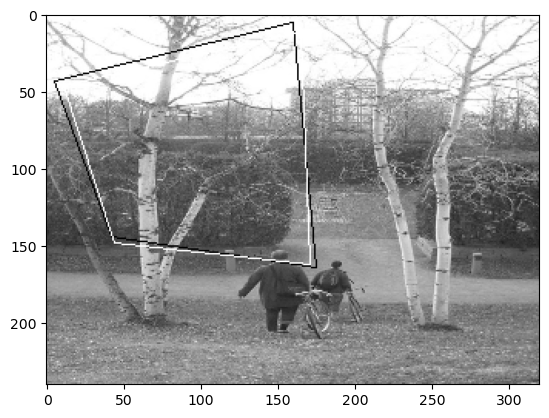

In [115]:
Visualize(model2, folder, files[3], plot_img = True)

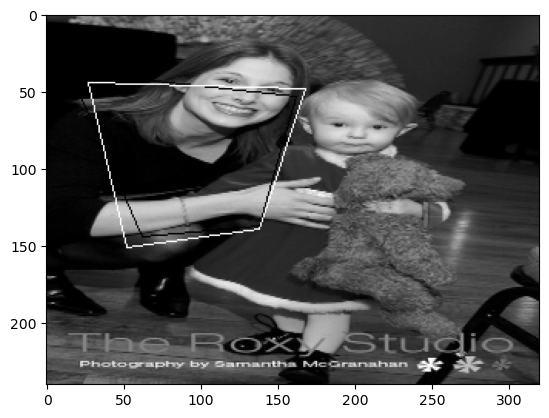

In [132]:
Visualize(model2, folder, files[50], plot_img = True)

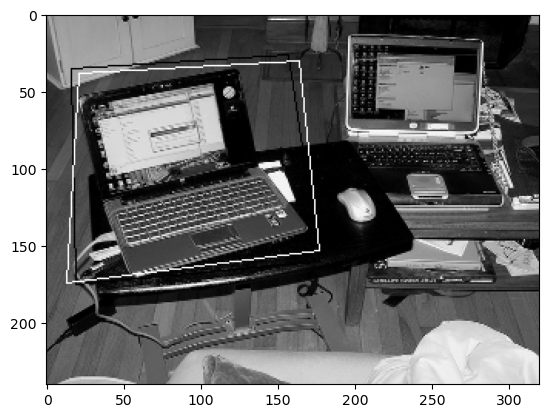

In [133]:
Visualize(model2, folder, files[100], plot_img = True)